In [4]:
from src.preprocessing import *
from functools import partial
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn.model_selection import train_test_split
import math
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [5]:
# read merged data
path = ".."
data = pd.read_csv("../data/final_merged_dataset.csv")
print("Example of merged data : ", data.sample(10))

Example of merged data :         Unnamed: 0                                              tweet  label
6193         6401  In Nagpur's Medical Hospital, the kidney of th...      0
15860       16077  Coronavirus Contains "HIV Insertions", Stoking...      0
1758         1758  Truth about Dettol products that are ‘proven t...      0
21777       21995  Cannabis May Stop Coronavirus From Infecting P...      0
29886       30107  If you have any pets, please have them with yo...      1
6212         6420  The results from a recent survey of GPs showed...      1
4764         4972  We get into the broader dynamics of falling ca...      1
14345       14559  The Plague https://t.co/ljx7vHEbVt #death #chi...      0
9731         9942  The spread of #COVID19 has been linked to larg...      1
7473         7681  Kate Middleton and Other Celebrities Spark Pre...      0


In [6]:
# preprocessing data

#Feature nb of retweets :

data['nb_retweets'] = data['tweet'].apply(count_retweets)

#Feature nb of mentions :

data['nb_mentions'] = data['tweet'].apply(count_mentions)

#Feature nb of urls:

data['nb_urls'] = data['tweet'].apply(count_urls)

#Feature nb of hashtags :

data['nb_hashtags'] = data['tweet'].apply(count_hashtags)

# Remove emojis :

data['tweet'] = data['tweet'].apply(remove_emojis)

# Remove retweets :

data['tweet'] = data['tweet'].apply(remove_retweets)

# Remove mentions :

data['tweet'] = data['tweet'].apply(remove_mentions)

# Remove urls :

data['tweet'] = data['tweet'].apply(remove_urls)

# Remove hashtags :

data['tweet'] = data['tweet'].apply(remove_hashtags)

# Replace slash chars (\n, \t, \r) by space :

data['tweet'] = data['tweet'].apply(replace_slash_chars_by_space)

# Remove underscore :

data['tweet'] = data['tweet'].apply(remove_underscore)

# To lowercase :

data['tweet'] = data['tweet'].apply(to_lowercase)

# Remove stopwords :

with open(path + "/data/english_stopwords.txt",mode="r") as f:
    stopwords = f.read().split('\n')

additional_stopwords = [] # to change
to_remove_stopwords = [] # to change

final_stopwords = [s for s in stopwords if s not in to_remove_stopwords]
final_stopwords += additional_stopwords

remove_stp_words = partial(remove_stopwords,list_stopwords=final_stopwords)

data['tweet'] = data['tweet'].apply(remove_stp_words)

# Remove additional white space :

data['tweet'] = data['tweet'].apply(remove_additional_space)

data.head()

,Unnamed: 0,tweet,label,nb_retweets,nb_mentions,nb_urls,nb_hashtags
0,0,two weeks coronavirus media coverage and: new ...,0,1,1,0,0
1,1,"ever here, congratulations, immune coronavirus",0,1,1,1,0
2,2,you’ve ever used frat house bathroom you’re im...,0,1,1,0,0
3,3,cocaine cures corona virus!! . got interesting...,0,1,1,0,0
4,4,it’s almost whole lot americans covid immune s...,0,1,1,0,0


In [7]:
## vectorize texts and split train test dataset
corpus = data["tweet"].tolist()
vect =CountVectorizer(min_df=0.,max_df=1.0)
X = vect.fit_transform(corpus)
y = data["label"]

>lr 0.914 (0.004)
>knn 0.842 (0.005)
>cart 0.871 (0.004)
>svm 0.905 (0.003)


/opt/anaconda3/envs/pytorch_py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/anaconda3/envs/pytorch_py3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

>stacking 0.919 (0.003)


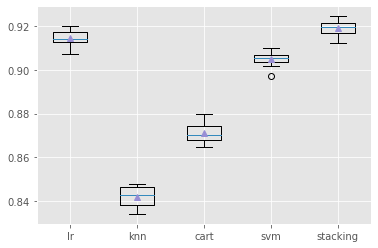

In [12]:
# compare ensemble to each baseline classifier
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot
from sklearn.ensemble import StackingClassifier
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC(kernel='linear')))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model
# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC(kernel='linear')
	models['stacking'] = get_stacking()
	return models
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()